## Step 0: Imports

In [33]:
import numpy as np
import pandas as pd
import scipy
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from scipy.stats import beta

## Step 1: Transform and split the data

In [34]:
kuairec_df = pd.read_csv('KuaiRec 2.0/data/small_matrix.csv')

In [35]:
kuairec_df['liked'] = kuairec_df['watch_ratio'] > 1.95
kuairec_df['liked'] = kuairec_df['liked'].astype(int)

In [36]:
video_df = kuairec_df.groupby(['video_id']).mean()['liked']

In [37]:
train_videos, test_videos = train_test_split(video_df, test_size = 0.4, random_state=1729)

In [38]:
# look up zero-inflated fits for beta, we're throwing out a small fraction of 0-like videos
prior_a, prior_b, loc, scale = beta.fit([i for i in train_videos.values if i != 0], floc=0, fscale=1)

In [39]:
print(prior_a, prior_b)

0.9492941782464519 16.534909180069906


In [40]:
r = beta.rvs(prior_a, prior_b, size=5000)

Text(0.5, 1.0, 'density plot of eb beta prior')

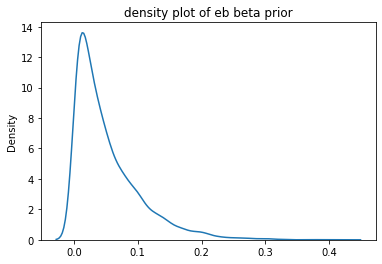

In [41]:
sns.kdeplot(r).set_title('density plot of eb beta prior')

In [42]:
video_df

video_id
103      0.025532
109      0.053154
120      0.102055
122      0.031228
128      0.023388
           ...   
10506    0.080351
10519    0.177098
10552    0.006383
10589    0.059914
10595    0.107988
Name: liked, Length: 3327, dtype: float64

## Step 2: Merge the datasets and select from test set different products

In [43]:
kuairec_test = pd.merge(kuairec_df, test_videos, on='video_id')
kuairec_test = kuairec_test.rename(columns={'liked_x': 'liked', 'liked_y': 'like_ratio'})

In [44]:
kuairec_test.head()

,user_id,video_id,play_duration,video_duration,time,date,timestamp,watch_ratio,liked,like_ratio
0,14,183,11635,6100,2020-07-05 05:28:00.057,20200705.0,1.593898e+09,1.907377,0,0.145996
1,19,183,8033,6100,2020-07-25 09:51:33.664,20200725.0,1.595642e+09,1.316885,0,0.145996
2,21,183,15770,6100,2020-07-08 07:00:20.865,20200708.0,1.594163e+09,2.585246,1,0.145996
3,23,183,20786,6100,2020-07-05 07:50:01.81,20200705.0,1.593907e+09,3.407541,1,0.145996
4,24,183,4737,6100,2020-07-05 03:47:59.561,20200705.0,1.593892e+09,0.776557,0,0.145996


Text(0.5, 1.0, 'histogram of like ratios')

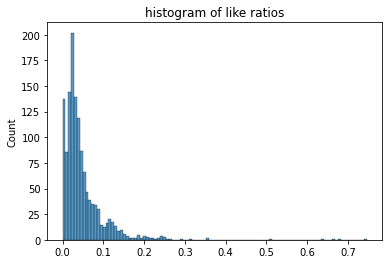

In [45]:
sns.histplot(test_videos.values).set_title('histogram of like ratios')

In [46]:
num_samples = 100

In [47]:
sampled_videos = (list(test_videos.sample(num_samples, random_state=1729).keys()))

In [48]:
kuairec_chosen = kuairec_test[kuairec_test['video_id'].isin(sampled_videos)]

In [49]:
video_df[sampled_videos].sort_values()

video_id
9136    0.000000
7566    0.000000
883     0.000000
8696    0.000000
4664    0.000709
          ...   
1205    0.122165
858     0.136782
2311    0.138396
2687    0.155209
7076    0.246634
Name: liked, Length: 100, dtype: float64

In [50]:
videos_of_interest = video_df[sampled_videos].sort_values()
videos_of_interest = list(videos_of_interest.iloc[[-1, -2, num_samples//5, 2*num_samples//5, 3*num_samples//5, 4*num_samples//5]].keys())
videos_of_interest

[7076, 2687, 2678, 627, 1377, 7257]

In [51]:
indices_of_interest = [sampled_videos.index(item) for item in videos_of_interest]

## Step 3: Set up the bandit environment

In [52]:
# set up experiment in a way where we can later interpolate between uninformed prior and eb
uninformed_priors = np.ones(len(sampled_videos)*2).reshape(len(sampled_videos),2)
eb_priors = np.array([[prior_a]*len(sampled_videos),[prior_b]*len(sampled_videos)]).T

In [53]:
def random_argmax(alist):
  maxval = max(alist)
  argmax = [idx for idx, val in enumerate(alist) if val == maxval]
  return np.random.choice(argmax)

def ts_action(actions, num_success, num_failure):
  p_hat = [np.random.beta(num_success[a],num_failure[a]) for a in actions]
  a = random_argmax(p_hat)
  return a

def greedy_action(actions, num_success, num_failure):
  p_hat = [(num_success[a] + 1) / (num_success[a] + num_failure[a] + 2) for a in actions]
  a = random_argmax(p_hat)
  return a

def epsilon_greedy_action(actions, num_success, num_failure):
  if np.random.binomial(1, 0.05):
    a = np.random.choice(actions)
  else:
    a = greedy_action(actions, num_success, num_failure)
  return a

def sample_chosen_df(videos, chosen_df, action_index):
    vid = videos[action_index]
    seen_like = chosen_df[chosen_df['video_id']==vid].sample(1).iloc[0]['liked']
    return seen_like

#### Default multi-armed bandit algorithm

In [59]:
def run_multiarmed_bandit(chosen_df, 
                          videos, 
                          priors, 
                          sampling_action, 
                          timesteps, 
                          num_sims):

    agg_priors_over_time = []
    rewards_over_time = []
    plays = []
    
    for n in range(num_sims):
        if (n+1) % 10 == 0:
            print(f'sim {n+1}/{num_sims}')
            
        instance_priors_over_time = [priors]
        instance_rewards_over_time = [np.zeros(len(videos))]
        instance_plays = np.zeros(len(videos))
        
        for t in range(timesteps):
            newest_prior = instance_priors_over_time[-1].copy()
            newest_rewards = instance_rewards_over_time[-1].copy()
            successes, failures = newest_prior.T[0,:], newest_prior.T[1,:]
            actions = range(len(videos))
            
            a = sampling_action(actions, successes, failures)
            
            instance_plays[a] += 1
            
            like = sample_chosen_df(videos, chosen_df, a)
            
            # update prior
            newest_prior[a,0] += like
            newest_prior[a,1] += 1 - like
            instance_priors_over_time.append(newest_prior)
            
            newest_rewards[a] += like
            instance_rewards_over_time.append(newest_rewards)
            
        instance_priors_over_time = np.stack(instance_priors_over_time)
        instance_rewards_over_time = np.stack(instance_rewards_over_time)
        
        agg_priors_over_time.append(instance_priors_over_time)
        rewards_over_time.append(instance_rewards_over_time)
        plays.append(instance_plays)
        
    agg_priors_over_time = np.stack(agg_priors_over_time)
    rewards_over_time = np.stack(rewards_over_time)
    plays = np.stack(plays)
            
    return agg_priors_over_time, rewards_over_time, plays
            
        

#### Multi-armed bandit with replenishment

In [83]:
def run_multiarmed_bandit_replenishment(chosen_df,
                                        videos,
                                        priors,
                                        sampling_action,
                                        timesteps,
                                        rho,
                                        num_sims,
                                        mkt_size,
                                        num_users=1):
    agg_priors_over_time = []
    rewards_over_time = []
    plays = []
    
    for n in range(num_sims):
        if (n+1) % 10 == 0:
            print(f'sim {n+1}/{num_sims}')
            
        curr_vids = np.array(list(np.random.choice(videos, mkt_size)))
        curr_vids_indices = np.array([videos.index(v) for v in curr_vids])
        remaining_vids = set(videos).difference(set(curr_vids))
        curr_chosen_df = chosen_df[chosen_df['video_id'].isin(curr_vids)]
            
        instance_priors_over_time = [priors]
        instance_rewards_over_time = [np.zeros(len(videos))]
        instance_plays = np.zeros(len(videos))
        
        for t in range(timesteps):
            # replenish the indices
            flips = np.random.binomial(1, rho, curr_vids_indices.shape[0])
            draws = np.random.choice(list(remaining_vids), mkt_size)
            
            new_draws_indices = np.array([videos.index(v) for v in draws])
            replenishments = flips * draws
            replaced = flips * curr_vids
            
            remaining_vids = remaining_vids.union(set(replaced[replaced != 0].flatten())
                                               ).difference(set(replenishments[replenishments != 0].flatten()))
            curr_vids = (1-flips) * curr_vids + flips * draws
            curr_vids_indices = (1-flips) * curr_vids_indices + flips * new_draws_indices
            curr_chosen_df = chosen_df[chosen_df['video_id'].isin(curr_vids)]
            
            newest_prior = instance_priors_over_time[-1].copy()
            newest_rewards = instance_rewards_over_time[-1].copy()
            successes, failures = newest_prior.T[0, curr_vids_indices], newest_prior.T[1, curr_vids_indices]
            actions = range(len(curr_vids))
            for m in range(num_users):
                a = curr_vids_indices[sampling_action(actions, successes, failures)]

                instance_plays[a] += 1

                like = sample_chosen_df(videos, chosen_df, a)

                # update prior
                newest_prior[a,0] += like
                newest_prior[a,1] += 1 - like
                newest_rewards[a] += like
            instance_priors_over_time.append(newest_prior)
            instance_rewards_over_time.append(newest_rewards)
            
        instance_priors_over_time = np.stack(instance_priors_over_time)
        instance_rewards_over_time = np.stack(instance_rewards_over_time)
        
        agg_priors_over_time.append(instance_priors_over_time)
        rewards_over_time.append(instance_rewards_over_time)
        plays.append(instance_plays)
        
    agg_priors_over_time = np.stack(agg_priors_over_time)
    rewards_over_time = np.stack(rewards_over_time)
    plays = np.stack(plays)
            
    return agg_priors_over_time, rewards_over_time, plays

## Step 4: Run the simulations and save data

In [68]:
timesteps = 10000
num_sims = 100
num_users = 10

In [84]:
uninformed_cycling_prior_data, uninformed_cycling_rewards_data, uninformed_cycling_plays_data = run_multiarmed_bandit_replenishment(kuairec_chosen,
                                                                                                                                    sampled_videos,
                                                                                                                                    uninformed_priors,
                                                                                                                                    ts_action,
                                                                                                                                    timesteps=timesteps,
                                                                                                                                    rho=0.05,
                                                                                                                                    num_sims=num_sims,
                                                                                                                                    mkt_size=10)

sim 10/100
sim 20/100
sim 30/100
sim 40/100
sim 50/100
sim 60/100
sim 70/100
sim 80/100
sim 90/100
sim 100/100


In [ ]:
eb_cycling_prior_data, eb_cycling_rewards_data, eb_cycling_plays_data = run_multiarmed_bandit_replenishment(kuairec_chosen,
                                                                                                            sampled_videos,
                                                                                                            eb_priors,
                                                                                                            ts_action,
                                                                                                            timesteps=timesteps,
                                                                                                            rho=0.05,
                                                                                                            num_sims=num_sims,
                                                                                                            mkt_size=10)

sim 10/100
sim 20/100
sim 30/100
sim 40/100
sim 50/100
sim 60/100
sim 70/100
sim 80/100
sim 90/100
sim 100/100


## Step 5: Plot and analyze the data

In [89]:
print(uninformed_cycling_prior_data.shape)
print(uninformed_cycling_rewards_data.shape)
print(uninformed_cycling_plays_data.shape)

(100, 10001, 100, 2)
(100, 10001, 100)
(100, 100)


In [91]:
uninformed_cycling_data = (uninformed_cycling_prior_data[:,:,indices_of_interest,0]/(uninformed_cycling_prior_data[:,:,indices_of_interest,0] + uninformed_cycling_prior_data[:,:,indices_of_interest,1]))
eb_cycling_data = (eb_cycling_prior_data[:,:,indices_of_interest,0]/(eb_cycling_prior_data[:,:,indices_of_interest,0]+eb_cycling_prior_data[:,:,indices_of_interest,1]))

uninformed_cycling_rewards = uninformed_cycling_rewards_data[:,:,indices_of_interest].mean(axis=0)
eb_cycling_rewards = eb_cycling_rewards_data[:,:,indices_of_interest].mean(axis=0)

uninformed_cycling_plays = uninformed_cycling_plays_data[:,indices_of_interest].mean(axis=0)
eb_cycling_plays = eb_cycling_plays_data[:,indices_of_interest].mean(axis=0)

In [92]:
# calculate means

uninformed_cycling_means = uninformed_cycling_data.mean(axis=0)
eb_cycling_means = eb_cycling_data.mean(axis=0)

In [93]:
# calculate confidence intervals

uninf_cycling_conf_width = beta.interval(0.95, uninformed_cycling_prior_data[:,:,indices_of_interest,0], uninformed_cycling_prior_data[:,:,indices_of_interest,1])
uninf_cycling_conf_width = uninf_cycling_conf_width[1] - uninf_cycling_conf_width[0]
uninf_cycling_conf_width = uninf_cycling_conf_width.mean(axis=0)

eb_cycling_conf_width = beta.interval(0.95, eb_cycling_prior_data[:,:,indices_of_interest,0], eb_cycling_prior_data[:,:,indices_of_interest,1])
eb_cycling_conf_width = eb_cycling_conf_width[1] - eb_cycling_conf_width[0]
eb_cycling_conf_width = eb_cycling_conf_width.mean(axis=0)

In [94]:
# calculate variance of quality

uninformed_cycling_vars = uninformed_cycling_data.var(axis=0)
eb_cycling_vars = eb_cycling_data.var(axis=0)

### 5.1: Plotting estimated quality, reward, confidence interval width, variance

In [150]:
def extract_relevant_data(a):
    li = np.zeros(a.shape)
    limit = []
    for i in range(a.shape[0]):
        for j in range(a.shape[2]):
            arr = a[i,:,j,:]
            arr = np.unique(arr, axis=0)
            buffer = arr[-1,:].copy()
            buffer = np.tile(buffer, (li.shape[1] - arr.shape[0],1))
            limit.append(arr.shape[0])
            arr = np.vstack([arr, buffer])
            li[i,:,j,:] = arr
    
    print(f'max limit {max(limit)}')
    return li[:,:max(limit),:,:]

In [147]:
uninformed_cycling_data_relevant = extract_relevant_data(uninformed_cycling_prior_data[:,:,indices_of_interest,:])

max limit 1214


In [155]:
eb_cycling_data_relevant = extract_relevant_data(eb_cycling_prior_data[:,:,indices_of_interest,:])

max limit 1325


true vals [0.2466, 0.1552, 0.0142, 0.0248, 0.039, 0.0716]
estimated means [0.2461 0.1496 0.0315 0.0389 0.0451 0.068 ]
arm pulls [833.09 500.07  44.34  52.9   67.24 122.06]


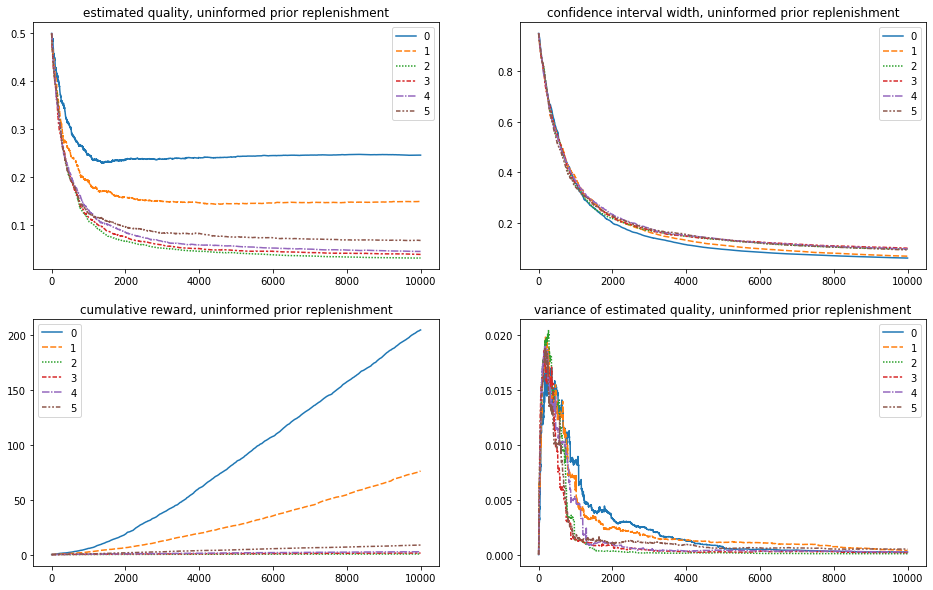

In [97]:
# TODO make the y axes consistent with one another
f, axes = plt.subplots(2,2)
f.set_size_inches(16,10)
sns.lineplot(uninformed_cycling_means, ax=axes[0,0]).set_title('estimated quality, uninformed prior replenishment')
sns.lineplot(uninformed_cycling_rewards, ax=axes[1,0]).set_title('cumulative reward, uninformed prior replenishment')
sns.lineplot(uninf_cycling_conf_width, ax=axes[0,1]).set_title('confidence interval width, uninformed prior replenishment')
sns.lineplot(uninformed_cycling_vars, ax=axes[1,1]).set_title('variance of estimated quality, uninformed prior replenishment')
print('true vals', list(video_df[videos_of_interest].values.round(4)))
print('estimated means', uninformed_cycling_means[-1,:].round(4))
print('arm pulls', uninformed_cycling_plays)

true vals [0.2466, 0.1552, 0.0142, 0.0248, 0.039, 0.0716]
estimated means [0.2461 0.1496 0.0315 0.0389 0.0451 0.068 ]
arm pulls [833.09 500.07  44.34  52.9   67.24 122.06]


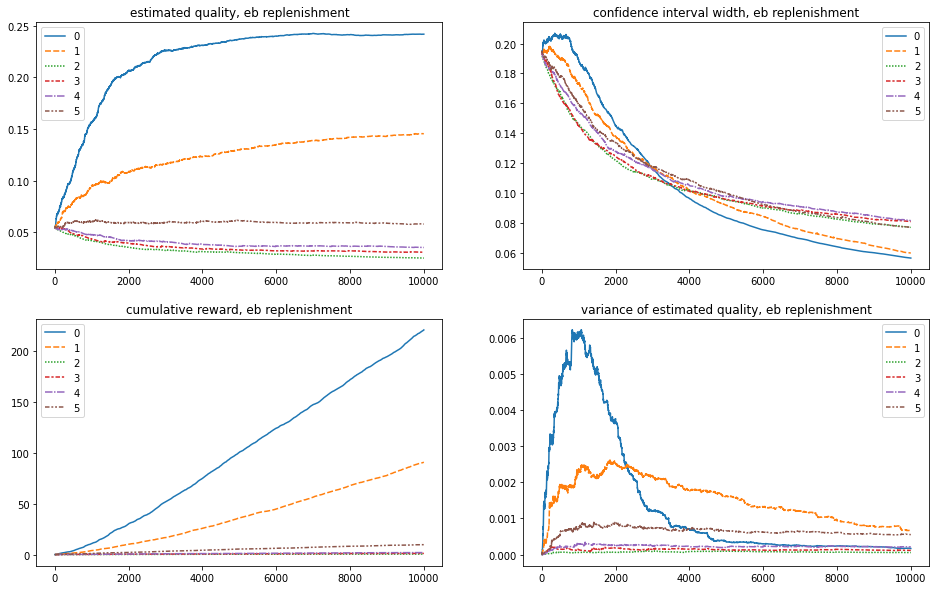

In [98]:
# TODO make the y axes consistent with one another
f, axes = plt.subplots(2,2)
f.set_size_inches(16,10)
sns.lineplot(eb_cycling_means, ax=axes[0,0]).set_title('estimated quality, eb replenishment')
sns.lineplot(eb_cycling_rewards, ax=axes[1,0]).set_title('cumulative reward, eb replenishment')
sns.lineplot(eb_cycling_conf_width, ax=axes[0,1]).set_title('confidence interval width, eb replenishment')
sns.lineplot(eb_cycling_vars, ax=axes[1,1]).set_title('variance of estimated quality, eb replenishment')
print('true vals', list(video_df[videos_of_interest].values.round(4)))
print('estimated means', uninformed_cycling_means[-1,:].round(4))
print('arm pulls', uninformed_cycling_plays)

### 5.2 Quality of products during relevant updates

In [159]:
def mean_data_to_df(data, videos_of_interest):
    li = []
    for i in range(data.shape[0]):
        df = pd.DataFrame(data[i,:,:])
        df = df.melt()
        df['timestep'] = list(range(data.shape[1]))*data.shape[2]
        df['sim #'] = i+1
        li.append(df)

    return pd.concat(li, ignore_index=True)

In [148]:
uninformed_cycling_means_relevant = uninformed_cycling_data_relevant[:,:,:,0]/(uninformed_cycling_data_relevant[:,:,:,0]+uninformed_cycling_data_relevant[:,:,:,1])

In [156]:
eb_cycling_means_relevant = eb_cycling_data_relevant[:,:,:,0]/(eb_cycling_data_relevant[:,:,:,0] + eb_cycling_data_relevant[:,:,:,1])

true vals [0.2466, 0.1552, 0.0142, 0.0248, 0.039, 0.0716]


Text(0.5, 1.0, 'quality of items, uninformed prior')

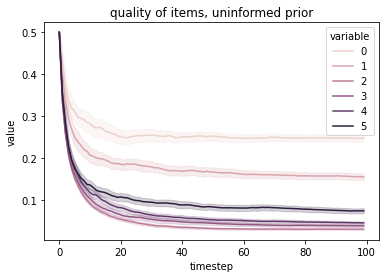

In [165]:
print('true vals', list(video_df[videos_of_interest].values.round(4)))
sns.lineplot(data=mean_data_to_df(uninformed_cycling_means_relevant[:,:100,:], videos_of_interest),
             x='timestep',
             y='value',
             hue='variable').set_title('quality of items, uninformed prior')

true vals [0.2466, 0.1552, 0.0142, 0.0248, 0.039, 0.0716]


Text(0.5, 1.0, 'quality of items, eb prior')

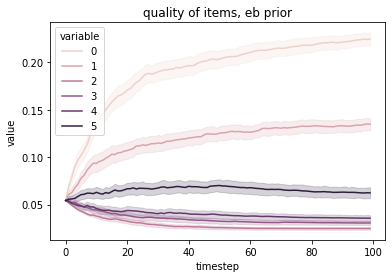

In [166]:
print('true vals', list(video_df[videos_of_interest].values.round(4)))
sns.lineplot(data=mean_data_to_df(eb_cycling_means_relevant[:,:100,:], videos_of_interest),
             x='timestep',
             y='value',
             hue='variable').set_title('quality of items, eb prior')